In [752]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from math import copysign

In [753]:
## All the funcions:

# EMA formula
def EMA(N, start_index, values):
    if (start_index >= len(values)):
        raise Exception("Index out of bounds!")
    

    multiplier = 0
    divisor = 0
    power = 0
    smoothing = 2 / (N + 1) # Smoothing factor, used in EMA function

    # We iterate over N elements in a reversed direction
    for index in range(start_index, start_index - N, -1):
        if (index < 0):
            break

        multiplier += values[index] * smoothing**power
        divisor += smoothing**power
        power += 1

    return (multiplier/divisor)

# EMA values list for n last elements
def EMA_values(N, n_elements, values):
    size = len(values)

    ema_values = []

    if n_elements > size:
        raise Exception("List length is smaller than number of elements!")
    
    start_index = size - n_elements

    #calculate ema for each element in the "scope"
    for index in range(start_index, size):
        ema_values.append(EMA(N, index, values))

    return ema_values

# MACD = EMA12 - EMA26
def MACD_values(n_elements, values):
    size = len(values)

    macd_values = []

    if n_elements > size:
        raise Exception("List length is smaller than number of elements!")

    ema12_values = EMA_values(12, n_elements, values)
    ema26_values = EMA_values(26, n_elements, values)

    #calculate ema difference for each element in the "scope"
    for index in range(0, n_elements):
        macd_values.append(ema12_values[index] - ema26_values[index])

    return macd_values

# Signal = EMA9 of the MACD values!
def Signal_values(n_elements, macd_values):
    return EMA_values(9, n_elements, macd_values)


# Plot formulas:

def plot_macd_signal(x_analyzed, macd_values, signal_values):
    plt.figure(figsize=(12, 6))
    plt.plot(x_analyzed, macd_values, label="MACD")
    plt.plot(x_analyzed, signal_values, label="Signal")
    plt.title("MACD and Signal")
    plt.legend()
    plt.show()
    

def plot_macd_signal_difference(x_analyzed, macd_signal_difference):
    # Create colors based on the sign of each value:
    colors = ['green' if val >= 0 else 'red' for val in macd_signal_difference]

    # Create the bar plot:
    plt.figure(figsize=(12, 6))
    plt.bar(x_analyzed, macd_signal_difference, color=colors)


    plt.title('MACD - Signal')

def plot_price_history(plot, x_analyzed, price_values, figsize=None,marker='', title='SOL Price History', y_label='Price per SOL unit', fill_range=None):
    if figsize != None:
        plot.figure(figsize=figsize)

    plot.plot(x_analyzed, price_values[x_analyzed[0]:x_analyzed[-1] + 1], marker=marker,  color='deepskyblue', linewidth=1)

    # Highlight analyzed segment by filling the area
    if fill_range != None:
        plot.fill_between(fill_range, 
                        price_values[fill_range[0]:fill_range[-1] + 1], 
                        color='lightgray', alpha=0.5, label="Analyzed Segment")

    if plot == plt:
        plot.title(title)
        plot.ylabel(y_label)
    else:
        plot.set_title(title)
        plot.set_ylabel(y_label)

    plot.grid()

def plot_transaction_on_price(x_analyzed, price_values, transactions, markersize=5):
    plot_price_history(plt, x_analyzed, price_values, (12, 6))

    # Get indexes where actions occur
    buy_indexes = np.where(transactions == 1)[0] + x_analyzed[0]
    sell_indexes = np.where(transactions == 2)[0] + x_analyzed[0]

    # For display, assign a y-value for markers. Here we use y=1 for buys and y=-1 for sells.
    y_buy = [price_values[i] for i in buy_indexes]
    y_sell = [price_values[i] for i in sell_indexes]

    # Create the plot
    plt.plot(buy_indexes, y_buy, 'g^', markersize=markersize, label='Buy')  # green upward triangles for buy
    plt.plot(sell_indexes, y_sell, 'rv', markersize=markersize, label='Sell')  # red downward triangles for sell
    plt.legend()

    return buy_indexes, sell_indexes

def plot_SOL_capital_history(plot, records_indexes, capital_history, figsize=None,marker='', title='SOL Capital History', y_label='Number of SOL units'):
    if figsize != None:
            plot.figure(figsize=figsize)
    
    plot.plot(records_indexes, capital_history, marker=marker, color='green')

    if plot == plt:
        plot.title(title)
        plot.ylabel(y_label)
    else:
        plot.set_title(title)
        plot.set_ylabel(y_label)
    
    plot.grid()

def plot_USD_capital_history(plot, x_analyzed, usd_history, lazy_values_USD, figsize=None,marker='', title='USD Capital History', y_label='Number of USD'):
    if figsize != None:
            plot.figure(figsize=figsize)

    plot.plot(x_analyzed, usd_history, color='orange',marker=marker, label='MACD trading')   
    plot.plot(x_analyzed, lazy_values_USD, color='gray',marker=marker, label='Lazy trading')

    if plot == plt:
        plot.title(title)
        plot.ylabel(y_label)
    else:
        plot.set_title(title)
        plot.set_ylabel(y_label)

    plot.legend()
    plot.grid()

def plot_profits(ax, delta_procent, title="Profits", ylabel="Percent Earned"):
    colors = ['green' if val >= 0 else 'red' for val in delta_procent]
    ax.bar(np.arange(len(delta_procent)), delta_procent, color=colors)
    ax.set_title(title)
    ax.set_ylabel(ylabel)

def plot_profits_circular_values(ax, profit_values, title="USD Income \nProportion"):
    positives = sum(val for val in profit_values if val > 0)
    negatives = abs(sum(val for val in profit_values if val < 0))
    full_sum = abs(sum(profit_values))
    
    sizes = [positives * 100 / full_sum, negatives * 100 / full_sum]
    labels = ['Positive', 'Negative']
    colors = ["green", "red"]

    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    ax.set_title(title)


def plot_combined_profits(plot, delta_procent, profit_values):
    _, (normal_plt, pie_plt) = plot.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})

    plot_profits(normal_plt, delta_procent)
    plot_profits_circular_values(pie_plt, profit_values)

    plot.tight_layout()
    plot.show()

def plot_combined_history(x_full, x_analyzed, price_values, records_indexes, capital_history, usd_history, lazy, profit_percent, profit_val):
    plt.figure(figsize=(18, 15))

    # Create subplots in a 5-row grid, adjusting the column span manually
    history_plt = plt.subplot2grid((5, 3), (0, 0), colspan=3)  # New row for full history with highlighted segment
    price_plt = plt.subplot2grid((5, 3), (1, 0), colspan=3)
    capital_plt = plt.subplot2grid((5, 3), (2, 0), colspan=3)
    usd_plt = plt.subplot2grid((5, 3), (3, 0), colspan=3)
    profits_plt = plt.subplot2grid((5, 3), (4, 0), colspan=2)  # Takes 2/3 of width
    pie_plt = plt.subplot2grid((5, 3), (4, 2))  # Takes 1/3 of width

    # Plot full price history with highlighted segment
    plot_price_history(history_plt, x_full, price_values, fill_range=x_analyzed, title='SOL Full Price History')

    # Plot SOL Price history
    plot_price_history(price_plt, x_analyzed, price_values, fill_range=x_analyzed)

    # Plot SOL Capital history
    plot_SOL_capital_history(capital_plt, records_indexes, capital_history)

    # Plot USD Capital history
    plot_USD_capital_history(usd_plt, records_indexes, usd_history, lazy)

    # Profits Section
    plot_profits(profits_plt, profit_percent)  # Profit bar chart (wider)
    plot_profits_circular_values(pie_plt, profit_val)  # Pie chart (smaller)

    plt.tight_layout()
    plt.show()


<bound method DataFrame.info of             time     Open     High      Low    Close      Volume
0     2021-01-01    1.510    1.865    1.495    1.847  1125773.54
1     2021-01-02    1.847    2.012    1.752    1.799  1060347.35
2     2021-01-03    1.799    2.808    2.007    2.185  1475936.63
3     2021-01-04    2.185    2.573    2.066    2.491  1543191.05
4     2021-01-05    2.491    2.634    2.145    2.158  1246011.66
...          ...      ...      ...      ...      ...         ...
1363  2024-09-25  152.720  153.880  147.300  147.970  1140072.57
1364  2024-09-26  147.970  158.030  146.590  155.580  1590861.37
1365  2024-09-27  155.580  161.240  154.010  157.640  1503547.66
1366  2024-09-28  157.640  159.400  155.080  156.780   576303.31
1367  2024-09-29  156.780  160.770  155.120  160.010   741062.22

[1368 rows x 6 columns]>


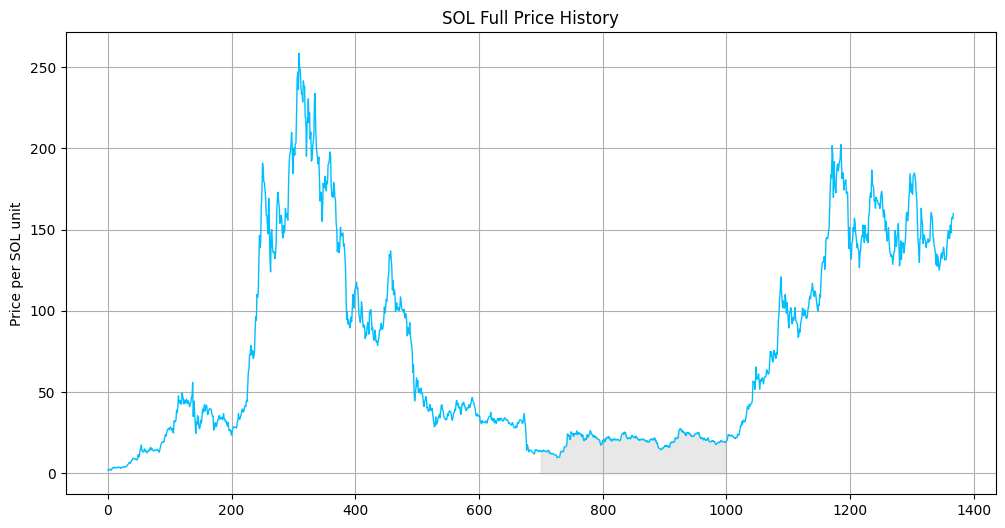

In [754]:
## Main data import and variables creation

data_frame = pd.read_csv("Solana_daily_data_2021_2024.csv")
print(data_frame.info)

close_data = data_frame.get("Close").tolist()   # Price and the end of the day
time_data = data_frame.get("time").tolist()     # Corresponding days

analyzed_from = 700
analyzed_to = 1000

n_records = len(close_data)
n_records_analyzed = analyzed_to - analyzed_from

x_full = list(np.arange(n_records))
x_analyzed = list(np.arange(analyzed_from, analyzed_to))


plot_price_history(plt, x_full, close_data, (12, 6), title='SOL Full Price History', fill_range=x_analyzed)

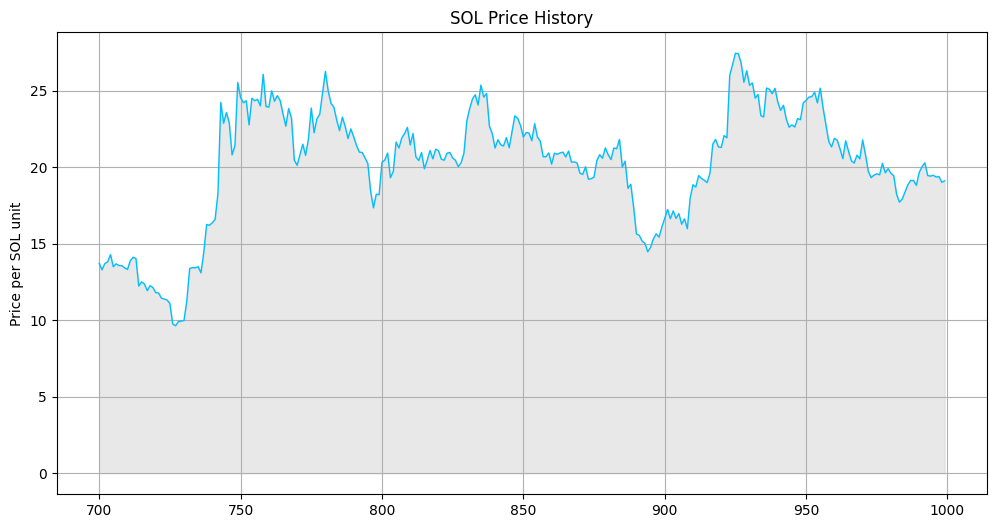

In [755]:
plot_price_history(plt, x_analyzed, close_data, (12, 6), fill_range=x_analyzed)

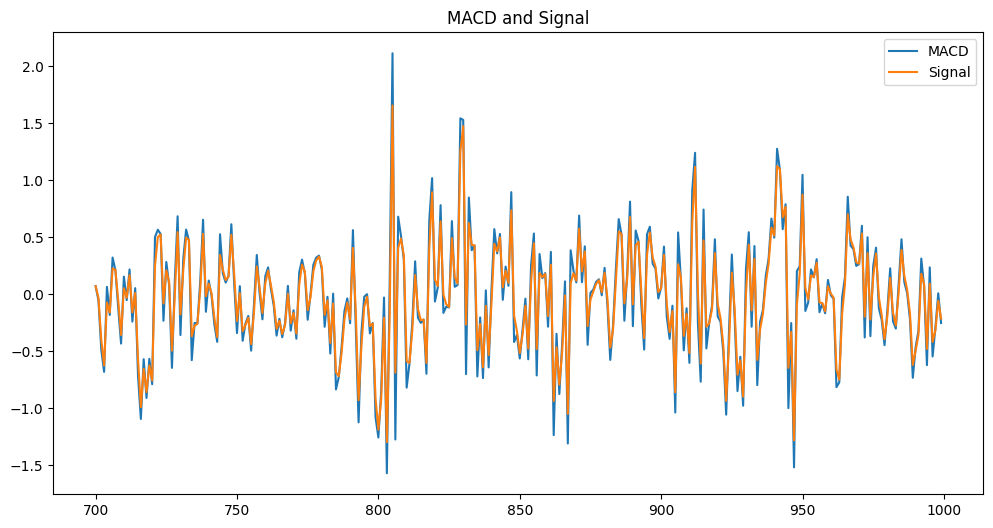

In [756]:
macd_values = MACD_values(n_records_analyzed, close_data)
signal_values = Signal_values(n_records_analyzed, macd_values)

plot_macd_signal(x_analyzed, macd_values, signal_values)


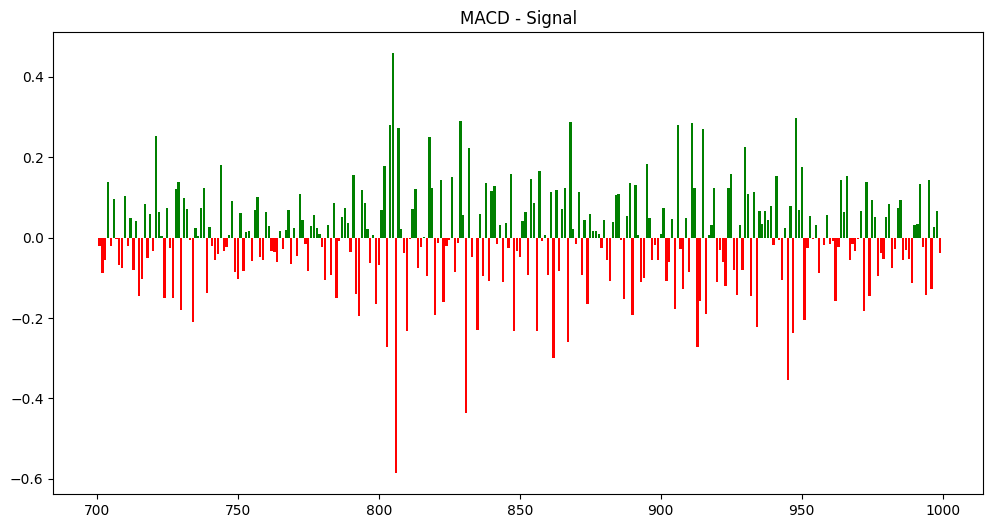

In [757]:
# For transaction decision me are interested in MACD Signal difference 
macd_signal_difference = np.subtract(macd_values, signal_values)

plot_macd_signal_difference(x_analyzed, macd_signal_difference)

In [758]:
# 0 - nothing, 1 - buy, 2 - sell
transactions = np.zeros(n_records_analyzed)
transactions[0] = 1
# 1 - keep, -1 - sell
current_state = 1

## TODO: iterate through 
for index in range(1, n_records_analyzed + 1):
    if copysign(1, macd_signal_difference[index - 1]) != current_state: # if the sign was changed
        if current_state == 1:
            current_state = -1
            transactions[index - 1] = 2 # sell
        else:
            current_state = 1
            transactions[index - 1] = 1 # buy

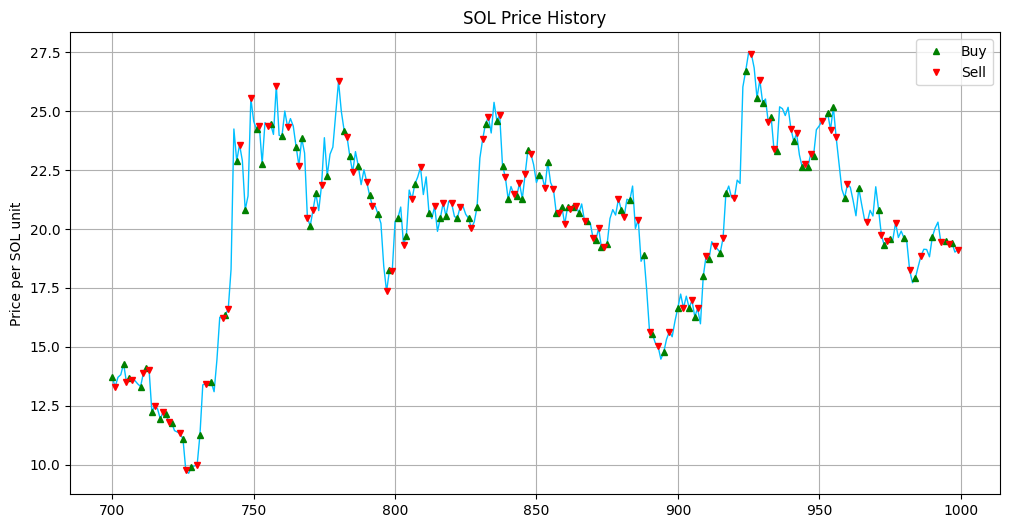

In [759]:
# Now let's plot buy and sell signals on trading history

buy_indexes, sell_indexes = plot_transaction_on_price(x_analyzed, close_data, transactions) 

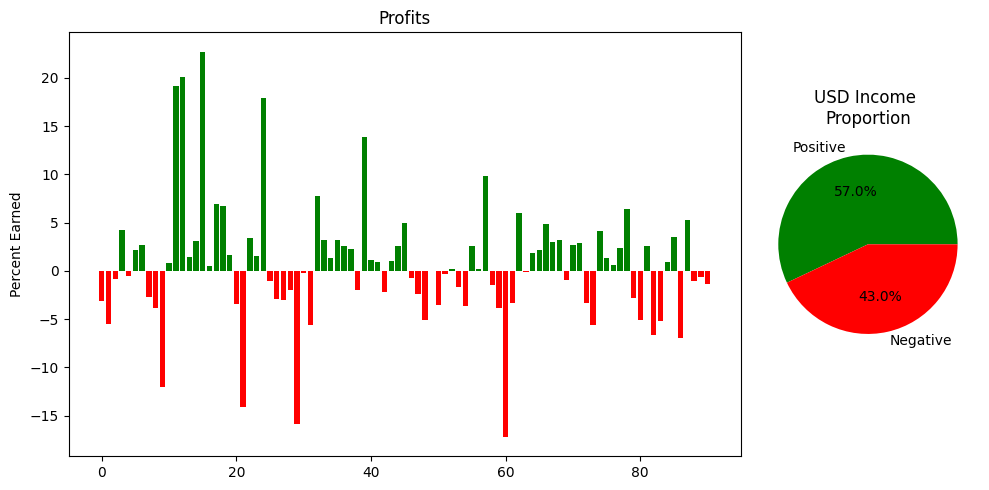

In [760]:
# Next we are going to calculate all the buy-sell transaction couples 
# and see, how many of them gave profit

paired_indexes = zip(buy_indexes, sell_indexes)
profits_value = []
profits_percent = []

for pair in paired_indexes:
    buy_price = close_data[pair[0]]
    sell_price = close_data[pair[1]]
    delta_price = sell_price - buy_price
    profits_value.append(delta_price)
    profits_percent.append(delta_price * 100 / buy_price)


plot_combined_profits(plt, profits_percent, profits_value)

In [761]:
# Simulation

start_capital_USD = 1000.0 # Number of USD at the beggining of our trading history
start_capital_SOL = start_capital_USD / close_data[x_analyzed[0]] # We are buying SOL at the beggining of our trading

capital = start_capital_SOL
capital_history = [capital]

for procent in profits_percent:
    capital = capital * (1 + procent / 100)
    capital_history.append(capital)

records_indexes = list()
records_indexes.append(int(buy_indexes[0]))
records_indexes = np.hstack((records_indexes, sell_indexes))

usd_history = []

for i in range(0, len(records_indexes)):
    usd_history.append(capital_history[i] * close_data[records_indexes[i]]) # number of units * unit price

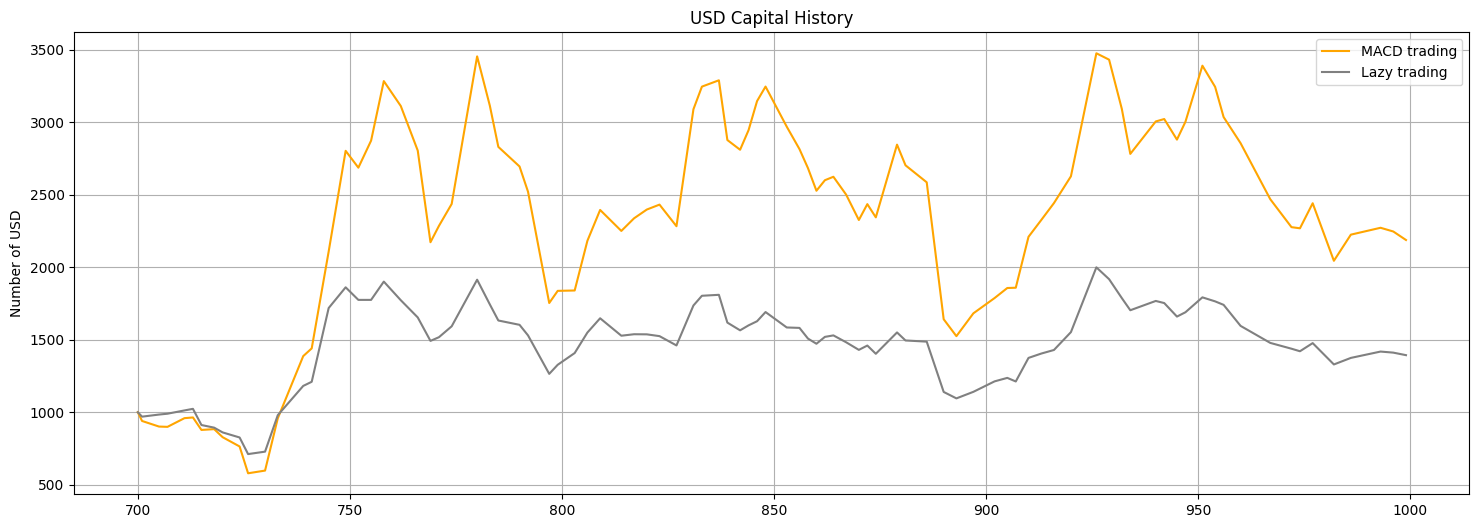

In [762]:
# Was it worth it?

lazy_values_USD = []

for record in records_indexes:
    lazy_values_USD.append(close_data[record] * start_capital_SOL)

# Profit made by the algorithm
profit_over_lazy = [not_lazy - lazy for not_lazy,lazy in zip(usd_history, lazy_values_USD)]

plot_USD_capital_history(plt, records_indexes, usd_history, lazy_values_USD, (18,6))

Initial capital (USD): 1000
Finish  capital (USD): 2187
Profit (USD): 1187
Profit (%): 118
Lazy profit (USD): 393
Lazy profit (%): 39


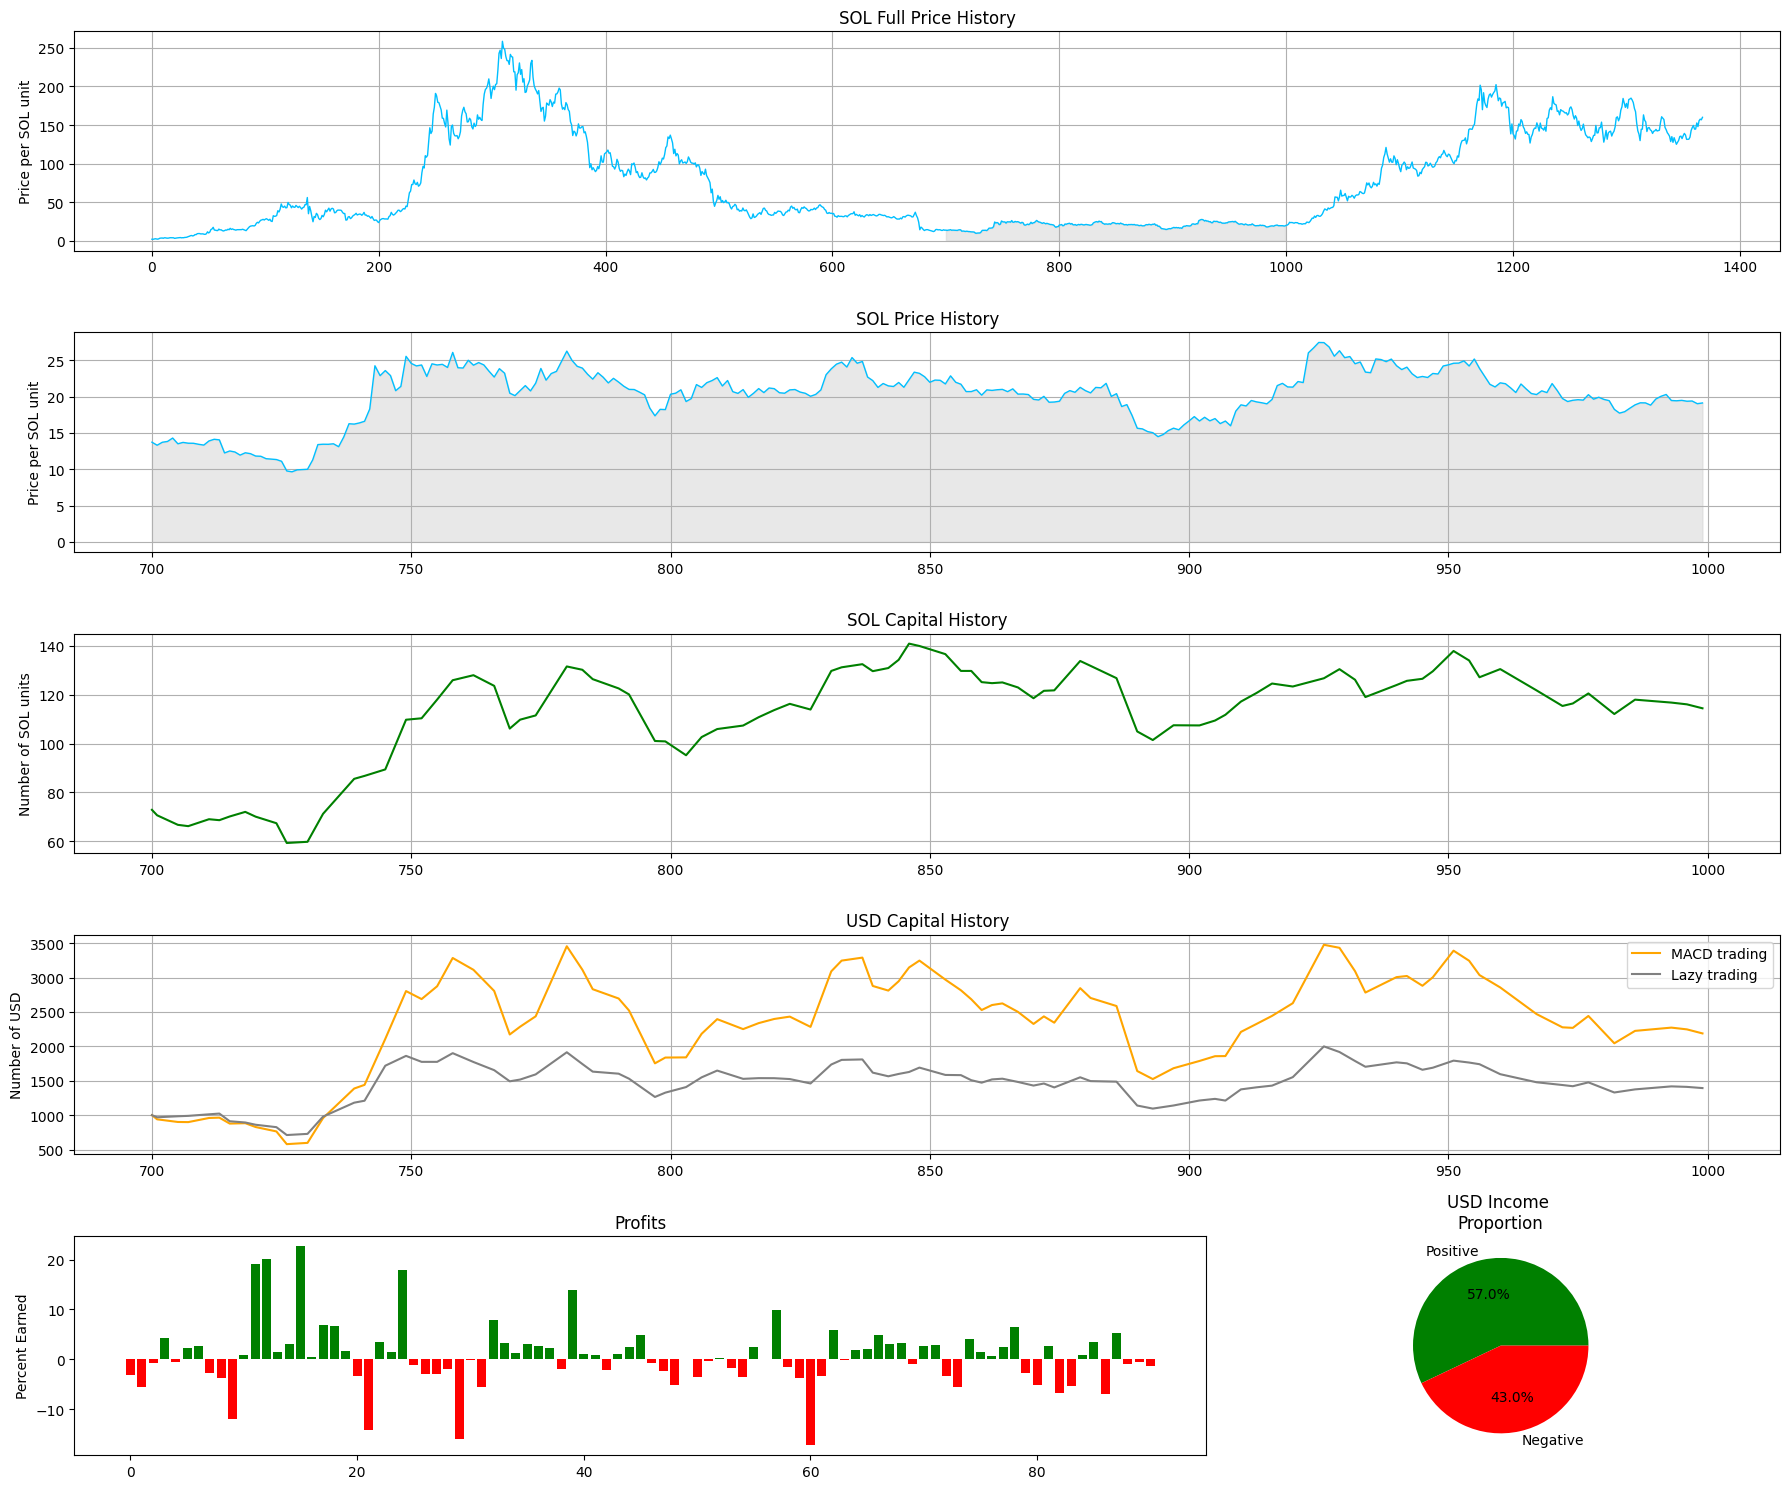

In [763]:
# Final results
start_USD = int(capital_history[0] * close_data[records_indexes[0]])
finish_USD = int(capital_history[-1] * close_data[records_indexes[-1]])
profit_USD = finish_USD - start_USD

print("Initial capital (USD):", start_USD)
print("Finish  capital (USD):", finish_USD)
print("Profit (USD):", profit_USD)
print("Profit (%):", profit_USD * 100 // start_USD)

lazy_finish_USD = int(capital_history[0] * close_data[records_indexes[-1]])
lazy_profit_USD = lazy_finish_USD - start_USD

print("Lazy profit (USD):", lazy_profit_USD)
print("Lazy profit (%):", lazy_profit_USD * 100 // start_USD)

plot_combined_history(x_full, x_analyzed, close_data, records_indexes, capital_history, usd_history, lazy_values_USD,profits_percent, profits_value)